# RNNs: uso di reti ricorrenti per previsioni di serie temporali

**Scopo:**
- acquistare familiarità con le RNN implementate in pytorch
-apprendere le idee di base di modelli di predizione per serie temporali



### Task

predire la qualità dell'aria (PM2.5) della città di Austin-TX sulla base delle rivelazioni fatte in comuni limitrofi

**Steps:**

1.   lettura e analisi del dataset
2.   preprocessamento dei dati
3.   implementazione e training del modello RNN
5.   valutazione delle prestazioni

**Dataset:**

PurpleAir data [link](https://map.purpleair.com/1/i/mPM25/a0/p604800/cC0#1.41/0/-30) per lo stato del Texas/US.
Contiene i valori di PM2.5 (mug/m^3) misurati dai sensori di 6 stazioni in Texas. I valori sono presi ogni 2 minuti dal 1.9.2021 al 21.10.2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

2.6.0+cu124
0.21.0+cu124


In [2]:
# Dataset download

!rm -rf processed_pm25.csv
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vYoaMemdYUX-qZDW5EMM6yrAMT_n9YAz' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1vYoaMemdYUX-qZDW5EMM6yrAMT_n9YAz" -O processed_pm25.csv && rm -rf /tmp/cookies.txt

--2025-04-16 08:59:25--  https://docs.google.com/uc?export=download&confirm=&id=1vYoaMemdYUX-qZDW5EMM6yrAMT_n9YAz
Resolving docs.google.com (docs.google.com)... 173.194.203.139, 173.194.203.101, 173.194.203.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.203.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1vYoaMemdYUX-qZDW5EMM6yrAMT_n9YAz&export=download [following]
--2025-04-16 08:59:25--  https://drive.usercontent.google.com/download?id=1vYoaMemdYUX-qZDW5EMM6yrAMT_n9YAz&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.203.132, 2607:f8b0:400e:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2163129 (2.1M) [application/octet-stream]
Saving to: ‘processed_pm25.csv’

processed_pm25.csv  100%[===================>]   2

In [3]:
# Lettura del dataset con pandas
df = pd.read_csv("processed_pm25.csv", index_col="created_at")
display(df)

,McAllen,Midlothian,Midland,Houston,Austin,Del Rio
created_at,,,,,,
2021-09-01 00:00:00+00:00,23.39,4.79,7.57,7.60,8.32,5.37
2021-09-01 00:02:00+00:00,23.02,4.60,8.50,7.78,8.93,5.95
2021-09-01 00:04:00+00:00,25.49,5.70,8.07,7.64,10.10,5.84
2021-09-01 00:06:00+00:00,25.22,5.18,8.66,7.69,9.24,7.07
2021-09-01 00:08:00+00:00,23.16,5.29,7.98,7.74,9.02,5.18
...,...,...,...,...,...,...
2021-10-21 23:50:00+00:00,2.58,9.18,12.62,7.80,13.14,8.31
2021-10-21 23:52:00+00:00,3.02,10.34,11.37,7.05,12.47,8.84
2021-10-21 23:54:00+00:00,2.37,10.28,11.82,6.93,12.34,8.57


In [4]:
display(df.describe())

,McAllen,Midlothian,Midland,Houston,Austin,Del Rio
count,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000
mean,13.619402,9.150556,9.064466,12.068240,11.186759,9.140742
std,9.954647,5.540314,6.224543,8.568262,7.226766,7.579689
min,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000
25%,6.190000,4.790000,4.620000,6.200000,6.090000,3.860000
50%,11.140000,8.460000,7.670000,10.890000,10.080000,7.570000
75%,19.070000,12.750000,11.820000,16.350000,14.380000,11.740000
max,150.390000,85.320000,237.890000,345.460000,86.070000,41.250000


In [5]:
display(df.corr())

,McAllen,Midlothian,Midland,Houston,Austin,Del Rio
McAllen,1.000000,0.156115,0.225225,0.154850,0.397872,0.453983
Midlothian,0.156115,1.000000,0.250901,0.289568,0.479188,0.254875
Midland,0.225225,0.250901,1.000000,0.118736,0.312648,0.429136
Houston,0.154850,0.289568,0.118736,1.000000,0.397394,0.114820
Austin,0.397872,0.479188,0.312648,0.397394,1.000000,0.609999
Del Rio,0.453983,0.254875,0.429136,0.114820,0.609999,1.000000


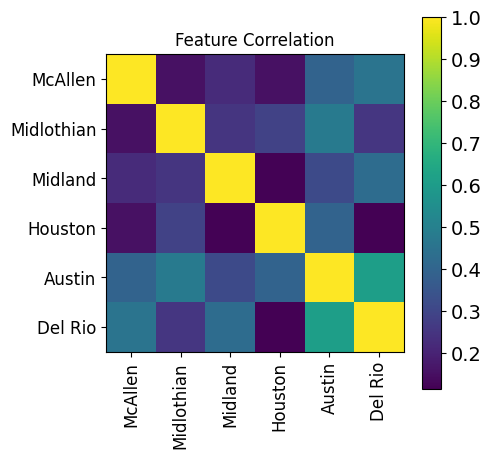

In [6]:
# plot correlazioni tra i sensori

plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation", fontsize=12)
plt.show()

(0.0, 60.0)

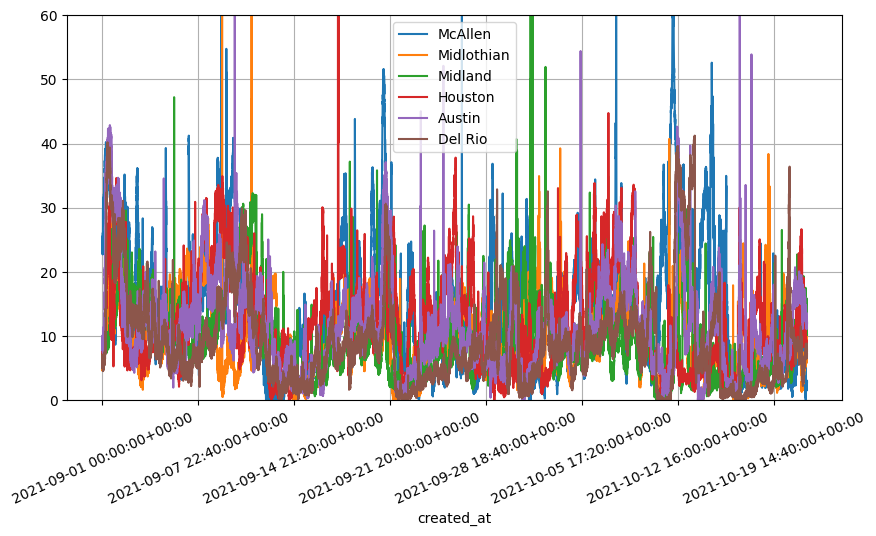

In [8]:
# plot features (PM2.5 vs data)
ax = df.plot(figsize=(10,5), rot=25)
plt.grid()
plt.ylim(0, 60)

['Del Rio', 'Houston', 'McAllen', 'Midland', 'Midlothian']


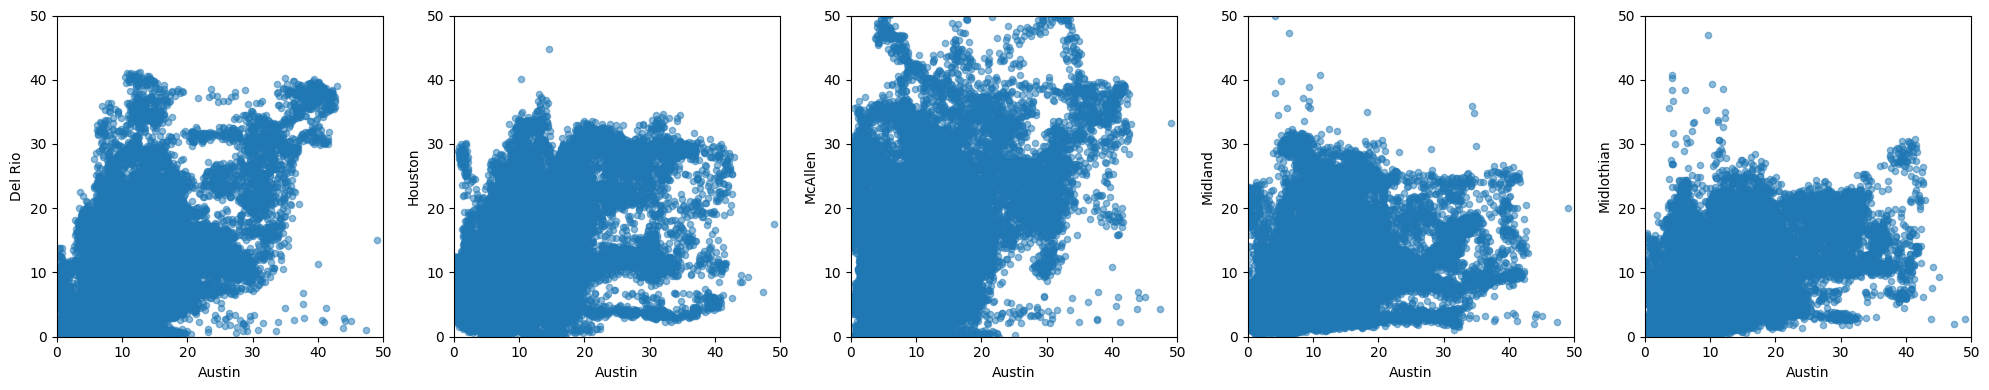

In [9]:
# plot correlazione PM2.5  Austin vs gli altri sensori
target_sensor = "Austin"
features = list(df.columns.difference([target_sensor]))
print(features)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(len(features)):
  _ = df.plot.scatter(ax=axs[i], x=target_sensor, y=features[i], alpha=0.5, xlim=(0,50), ylim=(0,50))
plt.tight_layout()

In [10]:
 # creazione del target

 # il task è quello di predire il PM2.5 ad Austin 30 minuti nel futuro sulla base dei PM2.5 misurati negli
 # altri sensori 30' prima

 # dobbiamo shiftare i valori della colonna di Austin 30' in avanti, poichè i dati sono acquisiti ogni 2'
 # dobbiamo shiftare di 15 step

# target_sensor = 'Austin'

forecast_step = 15
target = f"{target_sensor}_future{forecast_step}"
# Quello che sto facendo qui è semplicemente una concatenazione di stringhe: Austin_future15

df[target] = df[target_sensor].shift(-forecast_step)
# Qui sto creando la colonna target nella quale mette i valori di Austin partendo dal 15-esimo valore (quindi sono shiftati)

# elimino le ultime 15 righe del dataframe pandas che dopo lo shift non avranno valori a causa dello shift
df = df.iloc[:-forecast_step]

display(df.head(20))

,McAllen,Midlothian,Midland,Houston,Austin,Del Rio,Austin_future15
created_at,,,,,,,
2021-09-01 00:00:00+00:00,23.39,4.79,7.57,7.6000,8.32,5.37,7.80
2021-09-01 00:02:00+00:00,23.02,4.60,8.50,7.7800,8.93,5.95,7.74
2021-09-01 00:04:00+00:00,25.49,5.70,8.07,7.6400,10.10,5.84,8.69
2021-09-01 00:06:00+00:00,25.22,5.18,8.66,7.6900,9.24,7.07,7.91
2021-09-01 00:08:00+00:00,23.16,5.29,7.98,7.7400,9.02,5.18,9.10
2021-09-01 00:10:00+00:00,25.59,5.68,7.17,7.7000,8.96,6.14,7.73
2021-09-01 00:12:00+00:00,22.95,6.91,7.36,7.8900,8.72,5.60,8.43
2021-09-01 00:14:00+00:00,25.45,5.77,8.43,7.5800,8.79,4.96,8.02
2021-09-01 00:16:00+00:00,23.63,6.57,7.95,7.8100,8.60,5.54,7.39


In [13]:
# creazione di un test set per valutare le prestazioni del modello

# il dataset va dal 1.9.2021 al 21.10.2021, prendiamo come test set
# le acquiszioni dal 10.10.2021 al 21.10.2021
test_start = "2021-10-10"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print(f"Test set fraction: {(len(df_test) / len(df)):.2f}")

Test set fraction: 0.23


In [14]:
# normalizzazione delle feature e dei target, di norma migliora la convergenza della RNN e le prestazioni finali (!)

# standardizzo feature e target sottranedo la media e dividendo per la deviazione standard

# salvo per uso successivo mean e stdev del target
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
  mean = df_train[c].mean()  # uso solo i dati di training per ricavare media e stdev (avoid data leaks)
  stdev = df_train[c].std()
  df_train[c] = (df_train[c] - mean) / stdev
  df_test[c] = (df_test[c] - mean) / stdev

# Verifica
display(df_train.describe())
display(df_test.describe())

,McAllen,Midlothian,Midland,Houston,Austin,Del Rio,Austin_future15
count,2.808000e+04,2.808000e+04,2.808000e+04,2.808000e+04,2.808000e+04,2.808000e+04,2.808000e+04
mean,-2.550666e-16,4.048677e-17,-2.307746e-16,-6.477882e-17,1.376550e-16,-5.465713e-17,4.048677e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.495518e+00,-1.753982e+00,-1.516781e+00,-1.465819e+00,-1.636144e+00,-1.428631e+00,-1.636416e+00
25%,-7.097688e-01,-7.969831e-01,-6.811045e-01,-6.683694e-01,-6.879651e-01,-7.063620e-01,-6.881947e-01
50%,-2.142963e-01,-7.424019e-02,-2.415288e-01,-1.093452e-01,-1.678609e-01,-1.785498e-01,-1.666733e-01
75%,5.230735e-01,6.430550e-01,4.283008e-01,5.326752e-01,4.400894e-01,3.971050e-01,4.399091e-01
max,1.523043e+01,1.373959e+01,3.668605e+01,3.644741e+01,9.249791e+00,4.777020e+00,9.249996e+00


,McAllen,Midlothian,Midland,Houston,Austin,Del Rio,Austin_future15
count,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000
mean,0.083831,-0.392824,-0.675953,-0.600687,-0.324954,-0.075947,-0.324921
std,1.398186,0.967326,0.819304,0.482113,0.993329,1.601831,0.993462
min,-1.495518,-1.753982,-1.611781,-1.442772,-1.636144,-1.428631,-1.636416
25%,-1.040640,-1.123852,-1.218900,-0.969762,-1.008673,-1.211025,-1.008916
50%,-0.546836,-0.600862,-0.922630,-0.712131,-0.496935,-0.709449,-0.497156
75%,1.029112,0.165464,-0.447630,-0.286038,0.140297,0.293703,0.142893
max,5.748056,5.644146,3.173636,1.830983,10.365296,4.937525,10.365550


In [15]:
# creazione del dataset pytorch e del dataloader

# quello che vogliamo fare è passare una sequenza di osservazioni al modello per ogni istanza di training.
# il modo più semplice per farlo è quello di creare un pytorch dataset custom costruendo una classe python
# che erediti dalla classe torch.utils.data.Dataset

# la classe deve specificare cosa succede quando viene richiesto un dato elemento i del dataset (che nel nostro caso
# corrisponde ad una sequenza di righe della tabella pandas)

import torch
from torch.utils.data import Dataset

# fissato l'elemento i del dataset e la lunghezza della sequenza sequence_length ritorna
# i dati della sequenza da i-sequence_length a i. Qualora i-sequence_length<0 viene aggiunto
# un padding ripetendo la prima riga per il numero di occorrenze necessario per ottenre la lunghezza
# sequence_length richiesta

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features  # features
        self.target = target  # target
        self.sequence_length = sequence_length  # lunghezza dela sequenza
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    # il metodo __getitem__ implementa la logica del dataset
    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        outy = self.y[i]
        return x, outy

In [16]:
# test di funzionamento

i = 27
sequence_length = 4

prova_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

x, y = prova_dataset[i]
print(x)
print(y)

# 5 colonne una per sensore, 4 righe (elementi della sequenza)

tensor([[-0.6169, -0.6339,  1.7142, -0.2673, -0.4447],
        [-0.7110, -0.5878,  1.7398, -0.5040, -0.3920],
        [-0.6076, -0.6504,  1.4540, -0.4670, -0.6426],
        [-0.5212, -0.7055,  1.4973, -0.5217, -0.5373]])
tensor(-0.1597)


In [30]:
# Crezione dei dataset di train e test
from torch.utils.data import DataLoader
torch.manual_seed(101)

batch_size = 5
sequence_length = 30  # uso le rilevazioni nei 60' minuti precedenti nei 5 sensori per predire il valore di Austin

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))

print("Features shape:", x.shape)
print("Target shape:", y.shape)
print(x)

# shape dei tensori:
# x: (4,30,5) = (batch, lunghezza sequenza, numero feature)
# y: (4) = batch (il target è uno scalare il livello di PM2.5 di Austin)

Features shape: torch.Size([5, 30, 5])
Target shape: torch.Size([5])
tensor([[[-4.3011e-01, -5.0082e-02, -1.6425e-01, -1.3204e-01,  3.2900e-02],
         [-3.0356e-01, -8.3779e-03,  1.4494e-01, -2.1577e-01, -1.2498e-02],
         [-5.8290e-01,  1.4966e-01, -2.4115e-02, -5.9580e-02,  2.1631e-01],
         [-3.8227e-01,  1.4669e-02,  1.1936e-01,  1.1754e-01,  2.7260e-01],
         [-4.0696e-01,  4.2106e-02,  3.1955e-01,  1.4813e-01,  1.6728e-01],
         [-4.0850e-01,  6.8445e-02,  3.3512e-01,  3.2525e-01,  1.4741e-02],
         [-4.7641e-01,  9.6979e-02,  2.8173e-01,  5.5067e-01,  2.7987e-01],
         [-3.6683e-01,  4.1008e-02,  1.1713e-01,  7.9220e-01,  1.8907e-01],
         [-2.8504e-01,  1.0279e-02,  1.8052e-01,  9.7737e-01,  2.8168e-01],
         [-3.8998e-01,  6.6250e-02,  1.3493e-01,  6.2957e-01,  1.7636e-01],
         [-3.8690e-01,  8.0517e-02,  1.7035e-02,  3.8322e-01,  3.1800e-01],
         [-4.1159e-01,  5.6373e-02,  1.2380e-01,  3.7517e-01,  2.3992e-01],
         [-3.7455e-

In [31]:
# LSTM model definition
from torch import nn

class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim   # ovvero, il numero delle features
        self.hidden_dim = hidden_dim
        self.num_layers = 1  # usiamo una LSTM con un solo layer (non una stack LSTM)

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,  # necessario se l'input ha shape (batch, seq. len., features) altrimenti (seq.len., batch, features)
            num_layers=self.num_layers
        )

        # in uscita un layer denso con 1 neurone (il valore di PM2.5 di Austin)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        # valore iniziale per hidden state e cell state (inzializzato a zero)
        # NOTA: internamente per h e c pytorch usa la shape (numero di layers, batch size, hidden units)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()

        # ci interessa solo l'hidden state, quindi non consideriamo il cell state e l'output
        on, (hn, cn) = self.lstm(x, (h0, c0))

        # reshape the output on come (batch, seq, hidden)
        #on = on[:, -1, :]

        #print(on.shape)
        #print(hn.shape)

        out = self.linear(hn[0]).flatten()  # la prima dimensione di h è il numero di layers che è pari a 1
        #out = self.linear(on)
        return out

In [32]:
# definizione loss e optimizer

learning_rate = 5e-5
num_hidden_units = 4

model = myLSTM(input_dim=len(features), hidden_dim=num_hidden_units)

print(model)

loss_func = nn.MSELoss()  # MSE (è una regressione)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

myLSTM(
  (lstm): LSTM(5, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [33]:
# test del modello su un batch
xb, yb = next(iter(train_loader))
out = model(xb)
print(out.shape)

torch.Size([5])


In [35]:
# Training loop
import time

# numero di epoche
epochs = 10

# liste su cui salvare il valore della loss ad ogni epoca per poterla graficare in funzione
# dell'epoca a fine addestramento
hist_loss = []
hist_vloss = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    counter = 0

    for xb, yb in train_loader:
        counter += 1

        pred = model(xb)  # predizione del modello

        # calcolo loss
        loss = loss_func(pred.squeeze(), yb)

        # aggiorno la loss totale
        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()  # resetta i gradienti prima di eseguire la backpropagation
        loss.backward()  # calcola i gradeinti della loss
        opt.step()  # aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    counter = 0
    with torch.no_grad():  # evita che si aggiornino i pesi
      for xb, yb in test_loader:
        counter += 1

        pred = model(xb)  # predizione del modello

        # calcolo loss
        vloss = loss_func(pred.squeeze(), yb)

        vali_loss += vloss.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
          % (epoch+1, elapsed_time, train_loss, vali_loss))

epoch: 1, time(s): 13.5556, train loss: 0.756646, vali loss: 0.795058
epoch: 2, time(s): 12.1304, train loss: 0.524336, vali loss: 0.695226
epoch: 3, time(s): 12.1740, train loss: 0.442698, vali loss: 0.653845
epoch: 4, time(s): 13.2766, train loss: 0.400546, vali loss: 0.639465
epoch: 5, time(s): 12.3822, train loss: 0.375457, vali loss: 0.637307
epoch: 6, time(s): 12.4644, train loss: 0.358639, vali loss: 0.638084
epoch: 7, time(s): 12.3438, train loss: 0.346461, vali loss: 0.631960
epoch: 8, time(s): 12.3127, train loss: 0.337317, vali loss: 0.625907
epoch: 9, time(s): 12.1688, train loss: 0.330303, vali loss: 0.626384
epoch: 10, time(s): 12.1911, train loss: 0.324562, vali loss: 0.621623


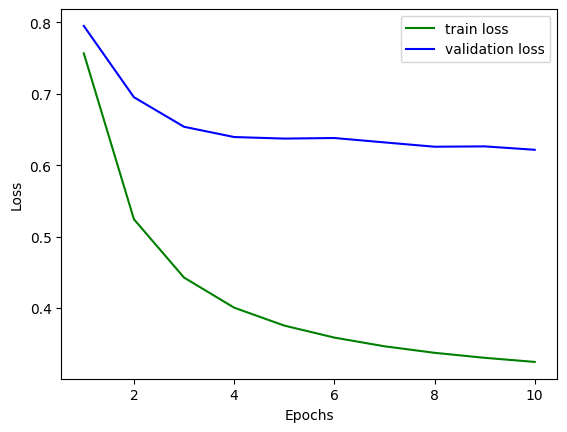

In [36]:
# grafico monitoring training
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [37]:
# Predizione
def predict(model, dataloader):
  output = torch.tensor([])
  model.eval()
  with torch.no_grad():
    for xb, _ in dataloader:
      pred = model(xb)
      output = torch.cat((output, pred), 0)
  return output

train_loader_eval = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

res_train = predict(model, train_loader_eval).numpy()
res_test = predict(model, test_loader).numpy()
df_test['prediction'] = res_test
df_train['prediction'] = res_train

df_out = pd.concat((df_train, df_test))[['Austin_future15', 'prediction']]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

display(df_out)

,Austin_future15,prediction
created_at,,
2021-09-01 00:00:00+00:00,7.80,6.597952
2021-09-01 00:02:00+00:00,7.74,6.746750
2021-09-01 00:04:00+00:00,8.69,7.016086
2021-09-01 00:06:00+00:00,7.91,7.322259
2021-09-01 00:08:00+00:00,9.10,7.075532
...,...,...
2021-10-21 23:20:00+00:00,13.14,8.807325
2021-10-21 23:22:00+00:00,12.47,8.769805
2021-10-21 23:24:00+00:00,12.34,9.175923


(0.0, 60.0)

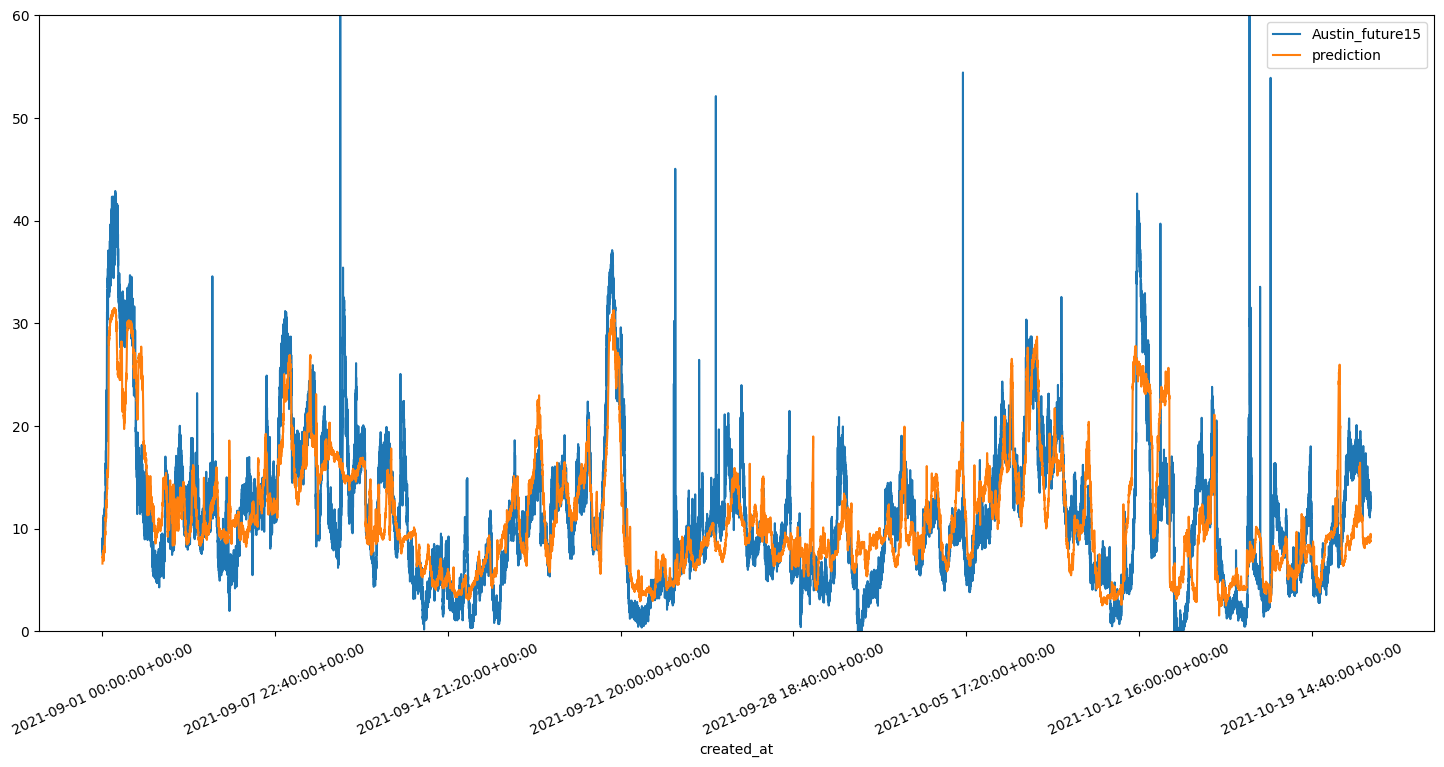

In [39]:
# plot prediction vs ground truth sequence
ax = df_out[['Austin_future15','prediction']].plot(figsize=(18,8), rot=25)
plt.ylim(0, 60)